In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!tar xvf "/content/drive/MyDrive/Cmpe_deep_learning/images.tar" -C "/content/drive/MyDrive/Cmpe_deep_learning/Multitask learning & Meta learning/images"

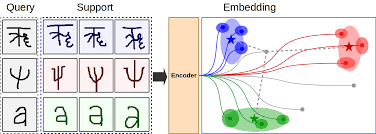
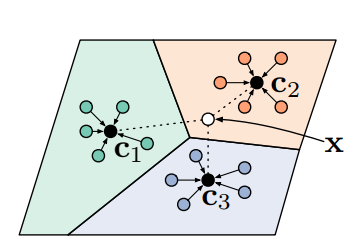

Data divides to query set and support set. Query set and support set are convert to embedding, or vectors format. In prototypical networks, we classify embeddings to clusters, and then we calculate the centroid of each cluster. To perform prediction, for example X (as image shown), we just find the distance between the centers and X; the one with a shortest distance is the classified result.

In [3]:
# import necessary libraries
import os

import numpy as np
import pandas as pd
import collections

In [4]:
from PIL import Image
import numpy as np
from torchvision import transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
# function to read csv files
def read_csv(csv_path):
    # create a dictionary to store the data
    dict = collections.defaultdict(list)
    df = pd.read_csv(csv_path)
    for index,row in df.iterrows():
        dict[row["label"]].append(row["filename"])
    return dict

In [6]:
train_csv_path = '/content/drive/MyDrive/Cmpe_deep_learning/Multitask learning & Meta learning/data/train.csv'
val_csv_path = '/content/drive/MyDrive/Cmpe_deep_learning/Multitask learning & Meta learning/data/val.csv'
test_csv_path = '/content/drive/MyDrive/Cmpe_deep_learning/Multitask learning & Meta learning/data/test.csv'

In [7]:
# if you want to run it in your local mechine,
# please download data from: https://github.com/cmpe130weifeng/cmpe297_hw4/tree/main/prototypical%20networks/data
train_dict = read_csv(train_csv_path)
val_dict = read_csv(val_csv_path)
test_dict = read_csv(test_csv_path)

In [8]:
# resize image to smaller size, it would save spaces 
resize_transform = transforms.Resize(84)

In [9]:
# you can download data from: https://www.kaggle.com/datasets/zcyzhchyu/mini-imagenet
img_root_dir = '/content/drive/MyDrive/Cmpe_deep_learning/Multitask learning & Meta learning/images'

# for each image, resize it to 84*84 and convert it to a numpy array
def build_data(data_dict):
    datas = []
    labels = []
    label_index = 0
    for label in data_dict.keys(): # loop to labels
        for path in data_dict[label]: # loop to based on label's name
            img_path = os.path.join(img_root_dir, path) 
            img = Image.open(img_path) # read image
            img = resize_transform(img) # transform image
            datas.append(img) 
            labels.append(label_index)

        label_index += 1
    return {"datas":datas,"labels":labels}

In [10]:
# build training, testing & validation data
train_data = build_data(train_dict)
val_data = build_data(val_dict)
test_data = build_data(test_dict)

In [11]:
from torch.utils.data import Dataset,DataLoader
import torch

# for few-shot learning
class CategoriesSampler():
    """
        purpose is to create K_way*(N_support+N_query) and its corresponding index
    """
    def __init__(self, data, n_batch, K_way, N_per):
        self.n_batch = n_batch
        self.K_way = K_way
        self.N_per = N_per
        labels = np.array(data["labels"]) # [0,0,0,0,1,1,1,1,2,2,2,2……]
        self.index = [] # save label's index
        for i in range(max(labels)+1): # for each label
            ind = np.argwhere(labels == i).reshape(-1) # find the index of the label
            self.index.append(torch.from_numpy(ind))   

    def __len__(self):
        return self.n_batch
    
    def __iter__(self):
        for i_batch in range(self.n_batch):  # for each batch 
            batch = []
            classes = torch.randperm(len(self.index))[:self.K_way] # randomly select support set & query set
            for c in classes:
                l = self.index[c] # find the index of the label
                pos = torch.randperm(len(l))[:self.N_per] # randomly select N_per images
                batch.append(l[pos]) 

            batch = torch.stack(batch).reshape(-1)
            yield batch

In [12]:
# class to create dataset
class MiniImageNet(Dataset):

    def __init__(self, data):

        self.datas = data["datas"]
        self.labels = data["labels"]
        self.transform = transforms.Compose([
            transforms.CenterCrop(84),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, i):
        img, label = self.datas[i], self.labels[i]
        return self.transform(img), label

In [13]:
import torch.nn as nn
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

# class to create model
class CNN_Net(nn.Module):
    """
        to extract features
    """

    def __init__(self, input_dim):
        super(CNN_Net, self).__init__()
        
        self.input_dim = input_dim

         # create a conv block
        def conv_block(in_channel,out_channel): 
            # create a sequential model
            return nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 3,padding=1), # convelutional layer
                nn.BatchNorm2d(out_channel), # batch normalization
                nn.ReLU(), # activation func
                nn.MaxPool2d(2) # max pooling
            )
        self.encoder = nn.Sequential(
            conv_block(input_dim,64), 
            conv_block(64,64), # you can see size is not reduced
            conv_block(64,64),
            conv_block(64,64),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return x

In [15]:
# prototypical networks
class Prototypicl_Net():
    def __init__(self, input_dim):

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")
        self.z_dim = 1600 # feature dimension
        self.cnn_net = CNN_Net(input_dim).to(self.device) # create a CNN_Net model
        
        # create training, testing, validation set
        self.train_dataset = MiniImageNet(train_data)
        self.val_dataset = MiniImageNet(val_data)
        self.test_dataset = MiniImageNet(test_data)

        # optimizer
        self.optimizer = torch.optim.Adam(self.cnn_net.parameters(), lr=0.001)
        # learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, 1, gamma=0.5, last_epoch=-1)
        print("useage：", self.device)

    # function that calculates the euclidean distance
    def cal_euc_distance(self, query_z, center,K_way, N_query):
        """
            compute distance between query_z and center
            query_z : (K_way*N_query,z_dim)
            center : (K_way,z_dim)
        """
        center = center.unsqueeze(0).expand(
            K_way*N_query, K_way, self.z_dim)  # (K_way*N_query,K_way,z_dim)
        query_z = query_z.unsqueeze(1).expand(
            K_way*N_query, K_way, self.z_dim)  # (K_way*N_query,K_way,z_dim)

        return torch.pow(query_z-center, 2).sum(2)  # (K_way*N_query,K_way)

    # function that calculates the loss and accuracy
    def loss_acc(self, query_z, center, K_way, N_query):
        """
            compute loss & accuracy
            query_z : (K_way*N_query,z_dim)
            center : (K_way,z_dim)
        """
        # create a target index
        target_inds = torch.arange(0, K_way).view(K_way, 1).expand(
            K_way, N_query).long().to(self.device) # shape=(K_way, N_query)
        
        distance = self.cal_euc_distance(query_z, center,K_way, N_query)    # (K_way*N_query,K_way) 
        predict_label = torch.argmin(distance, dim=1)  # (K_way*N_query) # predicted labels

        acc = torch.eq(target_inds.contiguous().view(-1),
                        predict_label).float().mean() # accuracy

        loss = F.log_softmax(-distance, dim=1).view(K_way,
                                                    N_query, K_way)  # (K_way,N_query,K_way)
        loss = - \
            loss.gather(dim=2, index=target_inds.unsqueeze(2)).view(-1).mean()
        return loss, acc

    def set_forward_loss(self, K_way, N_shot, N_query,sample_datas):
        """
            sample_datas： shape(K_way*(N_shot+N_query),3,84,84)
        """

        # convert support set&query set to vectors
        z = self.cnn_net(sample_datas) # shape=(K_way*(N_shot+N_query),z_dim) 
        # convert to 2D
        z = z.view(K_way,N_shot+N_query,-1) # shape = (K_way,N_shot+N_query,1600)
        
        support_z = z[:,:N_shot] # support set's vector; shape=(K_way,N_shot,1600)
        query_z = z[:,N_shot:].contiguous().view(K_way*N_query,-1) # Query set's vector; shape=(K_way*N_query,1600)
        
        center = torch.mean(support_z, dim=1) # compute support set centorid，shape=(K_way,1600)
        return self.loss_acc(query_z, center,K_way,N_query)

    def train(self, epochs, epoch_size):
        """
            training，randomly select classes with k samples。
        """
        K_way = 20
        N_shot = 5
        N_query = 15

        self.cnn_net.train()
        # create a sampler for training
        train_sampler = CategoriesSampler(train_data, epoch_size,K_way,N_shot+N_query)

        train_loader = DataLoader(dataset=self.train_dataset, batch_sampler=train_sampler,
                                    num_workers=16, pin_memory=True)

        for epoch in range(epochs):
            for i,batch_data in enumerate(train_loader):
                imgs,_ = batch_data[0].to(self.device),batch_data[1]
                loss, acc = self.set_forward_loss(K_way,N_shot,N_query,imgs)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            self.scheduler.step()

            val_acc1 = self.eval_model(val_data,self.val_dataset,5,1,15,600) 
            val_acc2 = self.eval_model(val_data,self.val_dataset,5,5,15,600) 
            
            test_acc1 = self.eval_model(test_data,self.test_dataset,5,1,15,600)
            
            test_acc2 = self.eval_model(test_data,self.test_dataset,5,5,15,600) 

            print("Training set：1-shot：{:.4},5-shot：{:.4}".format(val_acc1,val_acc2))
            
            print("Testing set：1-shot：{:.4},5-shot：{:.4}".format(test_acc1,test_acc2))
            
    # evuluate model
    def eval_model(self,datas,data_set,K_way,N_shot,N_query, eval_step):
        self.cnn_net.eval()
        batch_sampler = CategoriesSampler(datas,eval_step,K_way,N_shot+N_query)
        data_loader = DataLoader(dataset=data_set, batch_sampler=batch_sampler,
                                            num_workers=16, pin_memory=True)
        accs = []
        losses = []
        for i,batch_data in enumerate(data_loader):
            imgs,_ = batch_data[0].to(self.device),batch_data[1]
            loss, acc = self.set_forward_loss(K_way,N_shot,N_query,imgs)
            accs.append(acc.item())
            losses.append(loss.item())
        self.cnn_net.train()
        return sum(accs)/eval_step

In [18]:
net = Prototypicl_Net(3) # input_dim,K_way, N_shot, N_query
net.train(50, 2000)
#net.train(1, 2000)

useage： cpu


----------